In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from IPython.display import HTML
from IPython.display import Image

#Set working directory
import os
if "NOTEBOOK_DIR" not in globals():
    print('Notebook Directory Set:', os.getcwd())
    NOTEBOOK_DIR = os.getcwd()

os.chdir(os.path.join(NOTEBOOK_DIR, ".."))
print("Current working directory:", os.getcwd())

Notebook Directory Set: /shared_folder/nfl_data_bowl/notebooks
Current working directory: /shared_folder/nfl_data_bowl


In [3]:
#Importing Files
path = 'data/train'
file = path + '/input_2023_w01.csv'
df = pd.read_csv(file)

file = path + '/output_2023_w01.csv'
test_df = pd.read_csv(file)

supp_file = 'data/supplementary_data.csv'
supp_df = pd.read_csv(supp_file)

/tmp/ipykernel_49169/2456441876.py:10: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supp_df = pd.read_csv(supp_file)


In [4]:
#Create Field that draws entire football field for us to plot on
def create_field(linenumbers=False,
                 endzones = True,
                 highlight_line=False,
                 highlight_line_number=50,
                 figsize=(12, 6.33)):
    """
    Draws an NFL-style football field.
    
    Args:
        linenumbers (bool, False) : Tells to put linenumbers on plot
        highlight_line (bool, False) : Highlights line for usage of LOS
        highlight_line_number (int, 50) : Highlights line, default is 50 yard line
        figsize (tuple, (12, 6.33) : Draws size of plot

    Returns:
        fig : Figure object
        ax : Subplot of figure
    
    Coordinates:
        x in [0,120] 
        y in [0,53.3]
    """
    fig, ax = plt.subplots(figsize=figsize)

    # Field base
    field = Rectangle((0, 0), 120, 53.3, facecolor='mediumseagreen', zorder=0)
    ax.add_patch(field)

    # End zones
    if endzones:
        ez1 = Rectangle((0, 0), 10, 53.3, facecolor='lightgray', alpha=0.3, zorder=1)
        ez2 = Rectangle((110, 0), 10, 53.3, facecolor='lightgray', alpha=0.3, zorder=1)
        ax.add_patch(ez1); ax.add_patch(ez2)

    # Yard lines every 5 yards (thicker every 10)
    for x in range(10, 111, 5):
        lw = 2 if x % 10 == 0 else 1
        ax.plot([x, x], [0, 53.3], color='white', linewidth=lw, zorder=2)

    # Simple hash marks (can be refined for exact NFL placement)
    for x in range(11, 110):
        # small ticks near center and near sidelines (approximate)
        ax.plot([x, x], [0.4, 0.6], color='white', linewidth=0.8, zorder=2)
        ax.plot([x, x], [53.3-0.6, 53.3-0.4], color='white', linewidth=0.8, zorder=2)
        # center-area hashes
        ax.plot([x, x], [22.91, 22.91+0.2], color='white', linewidth=0.8, zorder=2)
        ax.plot([x, x], [53.3-22.91-0.2, 53.3-22.91], color='white', linewidth=0.8, zorder=2)

    # Yard numbers at standard positions (20..100)
    if linenumbers:
        for x in range(20, 101, 10):  # 20,30,...,100
            # number mapping: 10,20,30,40,50,40,30,20,10
            num = 50 - abs(60 - x)    # yields correct sequence
            txt = str(int(num))
            # lower numbers (facing viewer)
            ax.text(x, 5, txt, color='white', size=14, ha='center', va='center')
            # upper numbers (rotated 180 degrees so they read toward that sideline)
            ax.text(x, 53.3 - 5, txt, color='white', size=14, ha='center', va='center', rotation=180)

    # Optional highlight line (e.g., line of scrimmage)
    if highlight_line:
        ax.plot([highlight_line_number, highlight_line_number], [0, 53.3],
                color='blue', linewidth=1, zorder=3)

    # Final formatting
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_aspect('equal')
    ax.axis('off')

    return fig, ax

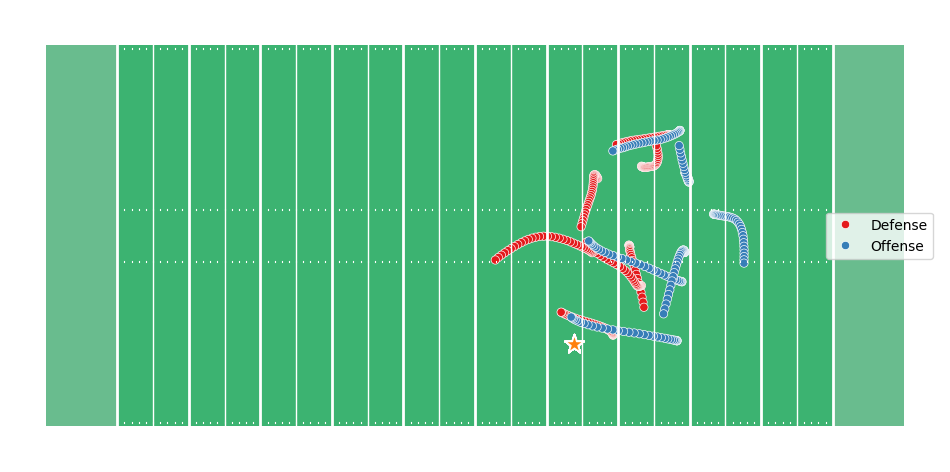

In [5]:
#Sample image using scatterplots on our Create Field Function
game_id = 2023091100
play_id = 3987

play_df = df[(df['game_id'] == game_id) & (df['play_id'] == play_id)]

create_field(linenumbers=False)
sns.scatterplot(data = play_df, x='x', y='y', hue='player_side', palette='Set1')
sns.scatterplot(data = play_df, x='ball_land_x', y='ball_land_y', marker='*', s=200)
plt.xlim(-5, 125)
plt.ylim(-5, 58.3)
plt.show()

In [6]:
#Create play draws random play or input play and plots on football field
#Get play is a helper that pulls specific df frame for create play
def get_play(df,
             game_id, 
             play_id):
    
    """
    Returns play dataframe given play, game_id, play_id for use in create_play()

    Args:
        df: dataframe to get data from
        game_id: game_id from dataframe
        play_id: play_id from dataframe and game_id

    Returns:
        DataFrame for use in plotting
    """

    return df[(df['game_id'] == game_id) & (df['play_id'] == play_id)]
    

def create_play(df,
                supp_df = supp_df,
                game_id = None, 
                play_id = None,
                visualize = False):
    
    """
    Creates Play given dataframe, game_id, play_id

    Args:
        df: dataframe to get data from
        game_id: game_id from dataframe
        play_id: play_id from dataframe and game_id
        visualize (False): tells to draw plot or not

    Returns:
        play_df: df image from get_play
        play_info: df image from supp_df of play info
        game_id: game_id from df
        play_id: play_id from df
        title: String for plotting title and quick sharing
        line: tells where to put line of scrimmage

    Plots:
        Play and all players and locations

    Raises:
        ValueError: If dataframe is empty, game_id invalid, play_id invalid
    """
    
    #Check input values
    if df.empty:
        raise ValueError('Input dataframe is empty')
    
    if not game_id and not play_id:
        game_id = int(np.random.choice(np.unique(df['game_id'])))
    elif not game_id:
        game_id = df[df['play_id'] == play_id]['game_id'].iloc[0]
    elif game_id not in list(df['game_id']):
        raise ValueError('game_id not in dataframe')
    
    if play_id == None:
        play_df = df[df['game_id'] == game_id]
        play_id = int(np.random.choice(np.unique(play_df['play_id'])))
    elif play_id not in list(df['play_id']):
        raise ValueError('play_id not in dataframe')

    #Use helper to get play dataframe
    play_df = get_play(df, game_id, play_id)

    #Get Line Number
    line = play_df.iloc[0].loc['absolute_yardline_number']

    #Use supplementary dataframe to get play info down and yards to go, quarter and time, and play description
    play_info = supp_df[(supp_df['game_id'] == game_id) & (supp_df['play_id'] == play_id)].iloc[0]
    description = play_info['play_description']
    while description[0] == '(':
        description = description.split(' ', 1)[-1]
    poss = play_info['possession_team']
    down = play_info['down']
    y_to_go = play_info['yards_to_go']
    side = play_info['yardline_side']
    yard = play_info['yardline_number']
    quarter = play_info['quarter']
    game_clock = play_info['game_clock']
    title = f'{poss} {down} & {y_to_go} on {side} {yard} | Qtr: {quarter} Time: {game_clock} | {description}'
    
    if visualize:
        #Use helper function to create field
        create_field(highlight_line = True, highlight_line_number = line)

        #Plot player and ball landing data
        sns.scatterplot(data = play_df, x='x', y='y', hue='player_side', palette='Set1')
        sns.scatterplot(data = play_df, x='ball_land_x', y='ball_land_y', marker='*', s=200)
        plt.title(title)
        plt.xlim(-5, 125)
        plt.ylim(-5, 58.3)
        plt.show()

    return (play_df, play_info, game_id, play_id, title, line)

In [7]:
#Creates animated play from create play output, can save with save_gif=True
def animate_play(play_df, 
                 play_info, 
                 game_id, 
                 play_id, 
                 title,
                 line,
                 save_gif=False):

    """
    Input data to have a gif or embedded video of the play prior to the pass play

    Args:
        play_df (DataFrame) : Give a DataFrame with all matching play_id and game_id
        play_info (DataFrame) : Give a DataFrame with play info from supp_df, not used in function. In for easy unpacking.
        game_id (Integer) : Give a game_id
        play_id (Integer) : Give a play_id
        title (String) : Give a title for the plays video/gif
        line (float) : Give a line value for the plot to show line of scrimmage
        save_gif (bool) : If true will save gif in folder

    Returns:
        if save_gif=False:
            returns animation for inline animation
        if save_gif=True:
            returns file name and saves animation as gif in play_gifs folder
    """

    #Sort Play Values
    play_df = play_df.sort_values(by=['frame_id'])

    #Create Field and boundaries
    fig, ax = create_field(highlight_line=True, highlight_line_number=line)
    ax.set_xlim(-5, 125)
    ax.set_ylim(-5, 58.3)
    ax.set_title(title)

    #Create default empty plots for O, D, QB, and intended receiver
    offense_plot, = ax.plot([], [], 'o', color='blue', label='Offense')
    defense_plot, = ax.plot([], [], 'o', color='red', label='Defense')
    qb_plot, = ax.plot([], [], 'o', color='white', label='Quarterback')
    target_plot, = ax.plot([], [], 'o', color='lime', label='Targeted Receiver')

    #Get Ball Marker Locations
    ball_land_x = play_df[play_df['frame_id']==1].iloc[0].loc['ball_land_x']
    ball_land_y = play_df[play_df['frame_id']==1].iloc[0].loc['ball_land_y']

    #Plot Ball
    ball_plot = ax.scatter(ball_land_x, ball_land_y, marker='*', s=100, label='Ball Landing', color='#FFD700', edgecolors='black', linewidths=0.8, zorder=5)
    ax.legend()

    #Update Function
    def update(frame):
        frame_df = play_df[play_df['frame_id'] == frame]
        offense_plot.set_data(frame_df.loc[frame_df['player_role'] == 'Other Route Runner', 'x'],
                              frame_df.loc[frame_df['player_role'] == 'Other Route Runner', 'y'])
        defense_plot.set_data(frame_df.loc[frame_df['player_role'] == 'Defensive Coverage', 'x'],
                              frame_df.loc[frame_df['player_role'] == 'Defensive Coverage', 'y'])
        qb_plot.set_data(frame_df.loc[frame_df['player_role'] == 'Passer', 'x'],
                         frame_df.loc[frame_df['player_role'] == 'Passer', 'y'])
        target_plot.set_data(frame_df.loc[frame_df['player_role'] == 'Targeted Receiver', 'x'],
                             frame_df.loc[frame_df['player_role'] == 'Targeted Receiver', 'y'])
        return offense_plot, defense_plot, qb_plot, target_plot

    #Get unique frame numbers and sort them so they play in order
    frames = sorted(play_df['frame_id'].unique())

    #Create Animation
    ani = animation.FuncAnimation(fig, update, frames=frames, blit=True, repeat=False, interval=100)

    #If Save Gif is true, create gif and save to file, else create embedded plot for playback
    if save_gif:
        gif_name = f"{game_id}_{play_id}.gif"
        ani.save("play_gifs/"+gif_name, writer='pillow', fps=10)
        print(f"Saved animation as {gif_name}")
        plt.close()
        return gif_name
    else:
        plt.close(fig)
        display(HTML(ani.to_jshtml(default_mode='loop') + "<script>animation.play();</script>"))
        return ani

In [8]:
test_play = animate_play(*create_play(df), save_gif=False)

In [9]:
test_play = animate_play(*create_play(df), save_gif=True)

Saved animation as 2023091004_2369.gif


In [10]:
test_play = animate_play(*create_play(df, game_id=2023090700, play_id=101))